# Setup

## Colab

In [1]:
# # # Mount the drive and move to dir
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# Switch to current dir
%cd /content/drive/MyDrive/Coding/spread-res/runscr/

/content/drive/MyDrive/Coding/spread-res/runscr


## Imports

In [2]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import sys
import os
import torch

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Import the utilities and the dataloader
from utils import trainutil, inferutil, setuputil

# Now reload the modules to ensure they are up-to-date
importlib.reload(setuputil)
importlib.reload(trainutil)
importlib.reload(inferutil)

# Import the funcs needed from utils
from utils.setuputil import setup_config, display_config
from utils.trainutil import train_unified
from utils.inferutil import infer_one, infer_full, binfer_one, binfer_full

## Configuration

In [3]:
input_config = {
    # Environment and Model Info
    "env": "colab",
    "approach": "bert",
    "model_name": "CustomSimpleBert",
    "model_base": "bert-base-cased",

    # System Configuration
    "device": "cuda:0",
    "threads": 10,
    "seed": 0,

    # Data Configuration
    "data_dir": "../data",
    "data_ds": "manual",

    # Model Parameters
    "rows": 100,
    "cols": 100,
    "tokens": 32,

    # BERT Architecture Parameters
    "vocab_size": 30522,
    "hidden_size": 128,
    "num_hidden_layers": 2,
    "num_attention_heads": 2,
    "intermediate_size": 256,

    # Training Parameters
    "batch": 12,
    "lr": 1e-3,
    "mu": 0.25,
    "epochs": 10,
    "patience": 2,
    "save_int": 0,
    "save_dir": "../models/",
}
config = setup_config(input_config)
display_config(config)

# Define local variables from the config dictionary
DEVICE = config["DEVICE"]
THREADS = config["THREADS"]

# Data loaders and vocab
train_loader = config["train_loader"]
val_loader = config["val_loader"]
test_loader = config["test_loader"]
tokenizer = config["tokenizer"]
model_base = config["model_base"]

# Training parameters
batch_size = config["batch"]
lr = config["lr"]
mu = config["mu"]
epochs = config["epochs"]
patience = config["patience"]
save_int = config["save_int"]
save_dir = config["save_dir"]
save_name = config["save_name"]

Processing files: 100%|██████████| 40/40 [00:09<00:00,  4.12it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 3400.60it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 2890.23it/s]



5(P) = 5(G) + 0(E)

Configuration for BERT approach:
{
  "env": "colab",
  "approach": "bert",
  "model_base": "bert-base-cased",
  "model_name": "CustomSimpleBert",
  "rows": 100,
  "cols": 100,
  "tokens": 32,
  "DEVICE": "cuda:0",
  "THREADS": 10,
  "seed": 0,
  "data_ds": "manual",
  "data_dir": "../data",
  "train_dir": "../data/manual_train",
  "val_dir": "../data/manual_val",
  "test_dir": "../data/manual_test",
  "vocab_size": 30522,
  "hidden_size": 128,
  "num_hidden_layers": 1,
  "num_attention_heads": 4,
  "intermediate_size": 512,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "max_position_embeddings": 64,
  "type_vocab_size": 2,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "pad_token_id": 0,
  "gradient_checkpointing": false,
  "tokenizer": "<BERT Tokenizer Object>",
  "train_loader": "<LoaderBert Object>",
  "val_loader": "<LoaderBert Object>",
  "test_loader": "<LoaderBert Object>",
  "batch": 12,
  "lr": 0.

# Model Creation

In [4]:
from transformers import BertModel, BertConfig
import torch.nn as nn
import torch
import math
from tqdm import tqdm


class SimpleBertEmbedAvg(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Define all params from config
        self.vocab_size = config["vocab_size"]
        self.hidden_size = config["hidden_size"]
        self.intermediate_size = config["intermediate_size"]
        self.num_hidden_layers = config["num_hidden_layers"]
        self.num_attention_heads = config["num_attention_heads"]
        self.hidden_act = config["hidden_act"]
        self.hidden_dropout_prob = config["hidden_dropout_prob"]
        self.attention_probs_dropout_prob = config["attention_probs_dropout_prob"]
        self.max_position_embeddings = config["max_position_embeddings"]
        self.type_vocab_size = config["type_vocab_size"]
        self.layer_norm_eps = config["layer_norm_eps"]
        self.initializer_range = config["initializer_range"]
        self.pad_token_id = config["pad_token_id"]
        self.gradient_checkpointing = config["gradient_checkpointing"]

        # Setup config with all params
        self.config = BertConfig(
            vocab_size=self.vocab_size,
            hidden_size=self.hidden_size,
            num_hidden_layers=self.num_hidden_layers,
            num_attention_heads=self.num_attention_heads,
            intermediate_size=self.intermediate_size,
            hidden_act=self.hidden_act,
            hidden_dropout_prob=self.hidden_dropout_prob,
            attention_probs_dropout_prob=self.attention_probs_dropout_prob,
            max_position_embeddings=self.max_position_embeddings,
            type_vocab_size=self.type_vocab_size,
            layer_norm_eps=self.layer_norm_eps,
            initializer_range=self.initializer_range,
            pad_token_id=self.pad_token_id,
            gradient_checkpointing=self.gradient_checkpointing
        )

        # Create BERT model from scratch (no pretrained weights)
        self.bert = BertModel(self.config)

        # Simple classification head with dropout from config
        self.dropout = nn.Dropout(self.hidden_dropout_prob)
        self.gelu = nn.GELU()
        self.classifier = nn.Linear(self.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        batch_size, rows, cols, seq_len = input_ids.shape
        S_cube = torch.zeros((batch_size, rows, cols), device=input_ids.device)

        # Process each cell with progress bar
        for cell in range(rows * cols):
            row = cell // cols
            col = cell % cols

            # Simple forward pass
            outputs = self.bert(
                input_ids=input_ids[:, row, col, :],
                attention_mask=attention_mask[:, row, col, :]
            )

            pooled = self.dropout(outputs.pooler_output)
            activated = self.gelu(pooled)
            logits = self.classifier(activated)
            S_cube[:, row, col] = logits.squeeze(-1)

        return S_cube

In [5]:
# 1) Create model and move to GPU Observe its architecture - 440 Mib
untrained_model = SimpleBertEmbedAvg(config).to(DEVICE)
print(untrained_model)

SimpleBertEmbedAvg(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(64, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_aff

# Model Training

In [6]:
# Train with adjusted batch size
trained_model = train_unified(
    untrained_model,
    train_loader,
    val_loader,
    DEVICE,
    batch_size=batch_size,
    lr=lr,
    mu=mu,
    max_epochs=epochs,
    patience=patience,
    save_int=save_int,
    save_dir=save_dir,
    save_name=save_name,
    config=config
)

Epoch 0


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.30s/it]


Train Loss: 1.3641037940979004, Perplexity: 1.0000454711602518
Val Loss: 1.329208254814148, Perplexity: 1.0000443079233943


Epoch 1


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.29s/it]


Train Loss: 1.2935509383678436, Perplexity: 1.0000431192942223
Val Loss: 1.100733757019043, Perplexity: 1.0000366917983616


Epoch 2


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.14s/it]


Train Loss: 0.9560510665178299, Perplexity: 1.0000318688766858
Val Loss: 0.639748215675354, Perplexity: 1.0000213251679007


Epoch 3


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.29s/it]


Train Loss: 0.5633741170167923, Perplexity: 1.000018779313563
Val Loss: 0.40445178747177124, Perplexity: 1.000013481817128


Epoch 4


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.28s/it]


Train Loss: 0.3823471963405609, Perplexity: 1.0000127449877614
Val Loss: 0.27033570408821106, Perplexity: 1.0000090112307372


Epoch 5


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.16s/it]


Train Loss: 0.26828764379024506, Perplexity: 1.0000089429614478
Val Loss: 0.20272554457187653, Perplexity: 1.0000067575409846


Epoch 6


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.32s/it]


Train Loss: 0.20908643305301666, Perplexity: 1.0000069695720557
Val Loss: 0.1682421863079071, Perplexity: 1.0000056080886022


Epoch 7


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.21s/it]


Train Loss: 0.16672879084944725, Perplexity: 1.0000055576418052
Val Loss: 0.1388387680053711, Perplexity: 1.0000046279696426


Epoch 8


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.15s/it]


Train Loss: 0.1401764713227749, Perplexity: 1.0000046725599605
Val Loss: 0.12236618995666504, Perplexity: 1.0000040788813171


Epoch 9


Validation Processing: 100%|██████████| 1/1 [00:16<00:00, 16.31s/it]


Train Loss: 0.1210964135825634, Perplexity: 1.0000040365552663
Val Loss: 0.10786983370780945, Perplexity: 1.000003595667588



TRAINING DONE at epoch 9, best epoch 9
Train Loss = 0.1210964135825634, Perplexity = 1.0000040365552663
Val Loss = 0.10786983370780945, Perplexity = 1.000003595667588



Filename: ../data/manual_train/portfoliobyloanstatus copy.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(4,10): 0.95669215917587280273
(4,6): 0.95693969726562500000
(4,4): 0.95711165666580200195
(16,0): 0.95714658498764038086
(20,0): 0.95720350742340087891
(4,8): 0.95721358060836791992
(12,0): 0.95722687244415283203
(4,14): 0.95722764730453491211
(6,0): 0.95725911855697631836
(32,0): 0.95730620622634887695
(24,0): 0.95732760429382324219
(8,0): 0.95734387636184692383
(9,1): 0.95742279291152954102
(4,12): 0.95742660760879516602
(6,1): 0.95743185281753540039
(5,0): 0.95744168758392333984
(38,0): 0.95744889974594116211
(28,0): 0.95744955539703369141
(7,1): 0.95745557546615600586
(8,1): 0.95745760202407836914
(37,1): 0.95747917890548706055
(36,0): 0.95748054981231689453
(4,2): 0.95749294757843017578
(0,0): 0.95749491453170776367
(5,3): 0.95749717950820922852
(5,2): 0.95750004053115844727

NB to B ratio: Predicted = 9873:127 | Actual = 9874:126
Accuracy: 99.91% | Precision: 96.06

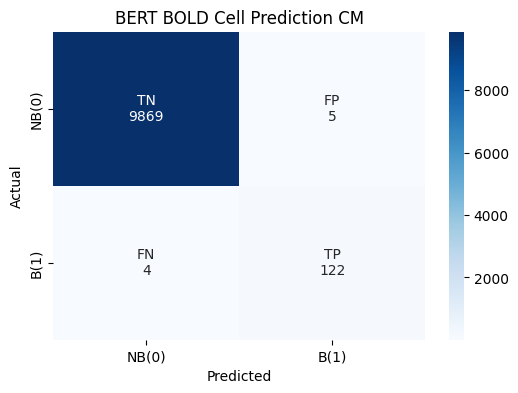


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,0,0,1,1,0,0,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# Params
loc = 0
thresh = 0.957
cond = '>'
disp_max=True

# inference on single position of train loader params
binfer_one(
    trained_model,
    train_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)


Filename: ../data/manual_val/ffelbydefermenttype.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(0,0): 0.95196986198425292969
(5,6): 0.95709508657455444336
(11,0): 0.95714658498764038086
(5,8): 0.95715022087097167969
(5,10): 0.95719993114471435547
(15,0): 0.95720350742340087891
(7,0): 0.95722687244415283203
(5,14): 0.95722764730453491211
(27,0): 0.95730620622634887695
(19,0): 0.95732760429382324219
(5,4): 0.95741677284240722656
(8,1): 0.95742279291152954102
(9,1): 0.95743185281753540039
(6,0): 0.95744168758392333984
(23,0): 0.95744955539703369141
(10,1): 0.95745557546615600586
(7,1): 0.95745760202407836914
(31,0): 0.95748054981231689453
(5,12): 0.95748561620712280273
(5,2): 0.95748585462570190430
(5,16): 0.95749574899673461914
(6,3): 0.95749717950820922852
(6,2): 0.95750004053115844727

NB to B ratio: Predicted = 9914:86 | Actual = 9896:104
Accuracy: 99.82% | Precision: 100.00% | Recall: 82.69% | F1-Score: 0.91



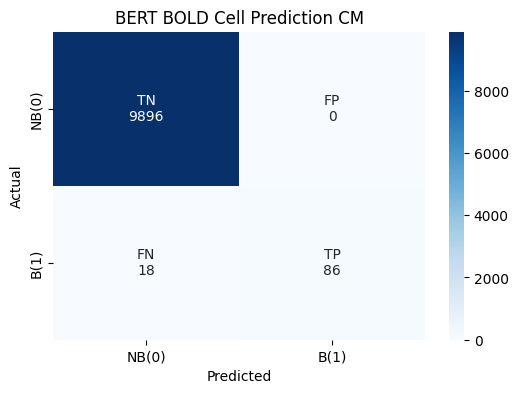


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
binfer_one(
    trained_model,
    val_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)


Filename: ../data/manual_test/dlportfoliobyrepaymentplan.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(5,16): 0.68862587213516235352
(5,4): 0.94068282842636108398
(5,2): 0.94685274362564086914
(5,14): 0.95096343755722045898
(5,18): 0.95318365097045898438
(5,8): 0.95434057712554931641
(5,6): 0.95546740293502807617
(17,0): 0.95714658498764038086
(21,0): 0.95720350742340087891
(13,0): 0.95722687244415283203
(5,20): 0.95722764730453491211
(7,0): 0.95725911855697631836
(33,0): 0.95730620622634887695
(25,0): 0.95732760429382324219
(9,0): 0.95734387636184692383
(10,1): 0.95742279291152954102
(7,1): 0.95743185281753540039
(6,0): 0.95744168758392333984
(29,0): 0.95744955539703369141
(8,1): 0.95745557546615600586
(9,1): 0.95745760202407836914
(37,0): 0.95748054981231689453
(0,0): 0.95748078823089599609
(5,10): 0.95749217271804809570
(6,3): 0.95749717950820922852
(6,2): 0.95750004053115844727
(5,12): 0.95750015974044799805

NB to B ratio: Predicted = 9886:114 | Actual = 9872:128
Accu

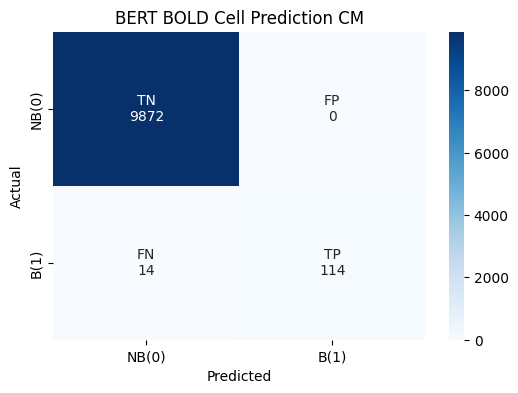


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
binfer_one(
    trained_model,
    test_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)

Batch Inference: 100%|██████████| 4/4 [01:03<00:00, 15.81s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 396694:3306 | Actual = 396714:3286
Accuracy: 99.95% | Precision: 97.35% | Recall: 97.03% | F1-Score: 0.97



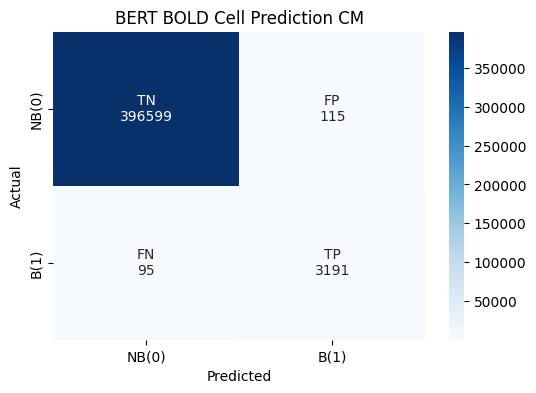

In [18]:
binfer_full(
    trained_model=trained_model,
    infer_loader=train_loader,
    batch_size=10,
    threshold=thresh,
    device=DEVICE
)

Batch Inference: 100%|██████████| 1/1 [00:15<00:00, 15.84s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49620:380 | Actual = 49602:398
Accuracy: 99.96% | Precision: 99.47% | Recall: 94.97% | F1-Score: 0.97



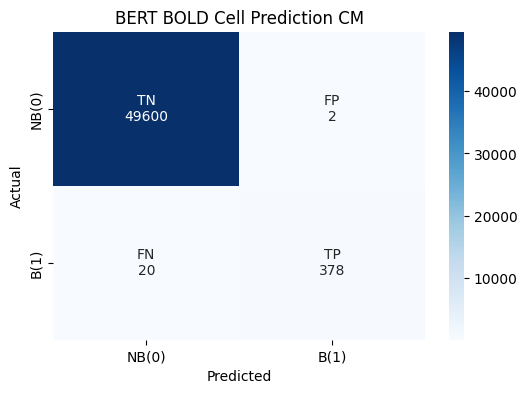

In [19]:
binfer_full(
    trained_model=trained_model,
    infer_loader=val_loader,
    batch_size=10,
    threshold=thresh,
    device=DEVICE
)

Batch Inference: 100%|██████████| 1/1 [00:15<00:00, 15.84s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49621:379 | Actual = 49606:394
Accuracy: 99.97% | Precision: 100.00% | Recall: 96.19% | F1-Score: 0.98



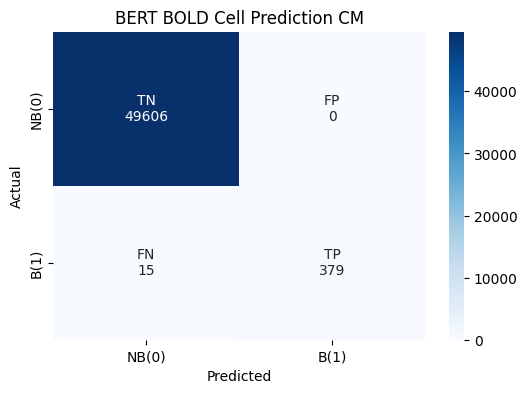

In [20]:
binfer_full(
    trained_model=trained_model,
    infer_loader=test_loader,
    batch_size=10,
    threshold=thresh,
    device=DEVICE
)